## Load Libraries

In [ ]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# parent folder of sound files
INPUT_DIR="../input/heartbeat-sounds"

In [ ]:
set_a=pd.read_csv(INPUT_DIR+"/set_a.csv")
set_a.head()

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [ ]:
set_a.tail()

dataset                     fname label  sublabel
171       a  set_a/__201108222241.wav   NaN       NaN
172       a  set_a/__201108222244.wav   NaN       NaN
173       a  set_a/__201108222247.wav   NaN       NaN
174       a  set_a/__201108222254.wav   NaN       NaN
175       a  set_a/__201108222257.wav   NaN       NaN

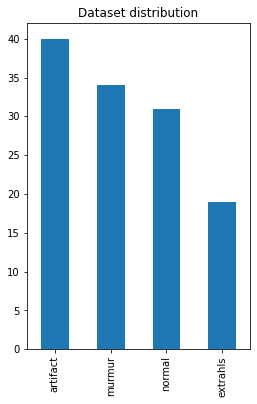

In [ ]:
plt.figure(figsize=(4,6))
set_a.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [ ]:
set_b=pd.read_csv(INPUT_DIR+"/set_b.csv")
set_b.head()

dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3       b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4       b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [ ]:
set_b.tail()

dataset                                              fname   label  \
651       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   
652       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   
653       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   
654       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   
655       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   

        sublabel  
651  noisynormal  
652  noisynormal  
653  noisynormal  
654  noisynormal  
655  noisynormal

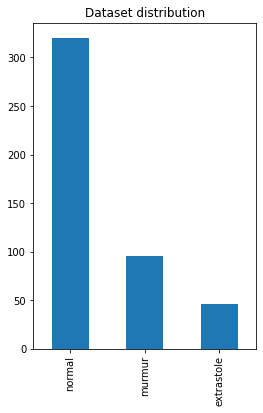

In [ ]:
plt.figure(figsize=(4,6))
set_b.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [ ]:
#merge both set-a and set-b
frames = [set_a, set_b]
complete=pd.concat(frames)
complete.describe()

dataset                             fname   label     sublabel
count      832                               832     585          149
unique       2                               832       5            2
top          b  set_a/artifact__201012172012.wav  normal  noisynormal
freq       656                                 1     351          120

In [ ]:
#get all unique labels
nb_classes=complete.label.unique()

print("Number of training examples=", complete.shape[0], "  Number of classes=", len(complete.label.unique()))
print (nb_classes)

Number of training examples= 832   Number of classes= 6
['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


1. Normal case
In the Normal category there are normal, healthy heart sounds. These may contain noise in the final second of the recording as the device is removed from the body. They may contain a variety of background noises (from traffic to radios). They may also contain occasional random noise corresponding to breathing, or brushing the microphone against clothing or skin. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” (when the heart rate is less than 140 beats per minute)(source: Rita Getz)

In [ ]:
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"

In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(normal_file) 

In [ ]:
# Load use wave 
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [ ]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


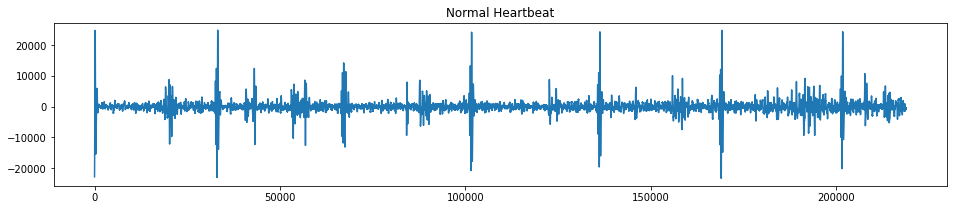

In [ ]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.title("Normal Heartbeat")
plt.plot(data, '-', );

In [ ]:
# Here's a sample generate mfccs from a wave file
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)

[[-8.2219505e+01 -1.4839169e+02 -4.0729141e+02 ... -3.6827591e+02
  -3.7412021e+02 -3.7713589e+02]
 [ 1.2423614e+02  1.2667972e+02  1.3922580e+02 ...  1.5181528e+02
   1.6177580e+02  1.6008926e+02]
 [ 1.6999889e+01  1.9273008e+01  1.9956818e+01 ...  2.8723314e+01
   2.5671349e+01  3.3645073e+01]
 ...
 [-2.3263998e-01  3.4405047e-01 -1.3570172e+00 ...  1.1671162e-01
   3.4991908e-01  1.7624778e+00]
 [-3.2621369e+00 -2.6241364e+00  4.8796743e-02 ...  2.1639774e+00
   2.1528602e-03  4.9950171e+00]
 [ 3.2704529e-01  8.1956828e-01 -2.9419889e+00 ...  2.7688107e+00
  -1.4733911e+00  8.5162938e-01]]


In [ ]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-6.1958321e+01 -1.2798345e+02 -3.9028296e+02 ... -3.5058408e+02
  -3.5407120e+02 -3.5772101e+02]
 [ 1.1372986e+02  1.1643681e+02  1.3576581e+02 ...  1.4986203e+02
   1.5767545e+02  1.5704291e+02]
 [ 2.1990515e+01  2.4387222e+01  1.1875902e+01 ...  2.0178385e+01
   1.8738266e+01  2.7693466e+01]
 ...
 [-1.3774414e+00 -7.9384041e-01 -2.0633023e+00 ...  2.9103904e+00
  -1.4163526e+00  2.0738344e+00]
 [-2.6485703e+00 -2.2959366e+00 -3.4820907e+00 ...  1.3710890e+00
   3.5719186e-02 -1.3605812e+00]
 [-4.1418257e+00 -4.1648932e+00 -1.6856954e+00 ...  4.1964483e-01
   6.4374655e-01 -4.1341019e+00]]


In [ ]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)

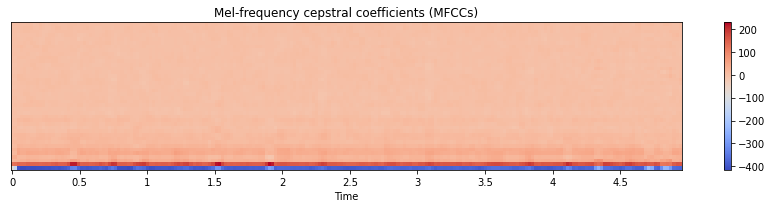

In [ ]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

In [ ]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([0.48761905, 0.7662585 , 0.95201814, 1.25387755, 1.55573696,
       1.92725624, 2.32199546, 2.80961451, 3.11147392, 3.80807256,
       3.85451247, 4.13315193, 4.36535147, 4.59755102, 4.73687075,
       4.85297052])

In [ ]:
# use a pre-computed onset envelope



o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

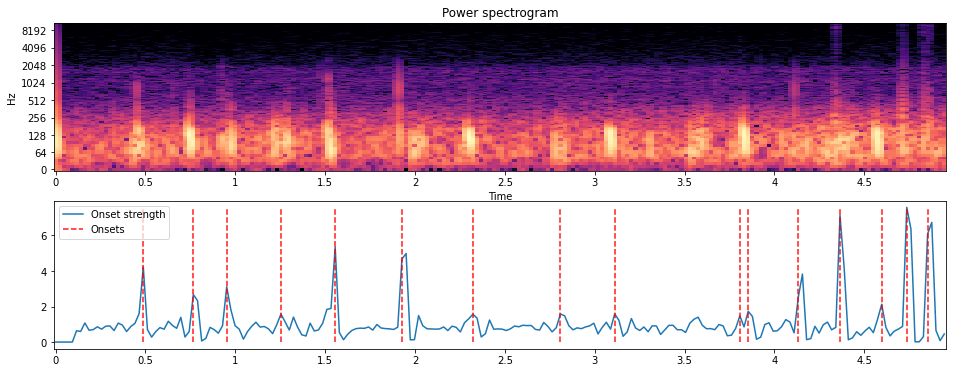

In [ ]:
# visualize it

D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

2. Murmur
Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”. One of the things that confuses non-medically trained people is that murmurs happen between lub and dub or between dub and lub; not on lub and not on dub.(source: Rita Getz)

In [ ]:
# murmur case
murmur_file=INPUT_DIR+"/set_a/murmur__201108222231.wav"
y2, sr2 = librosa.load(murmur_file)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(174979,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(murmur_file) 

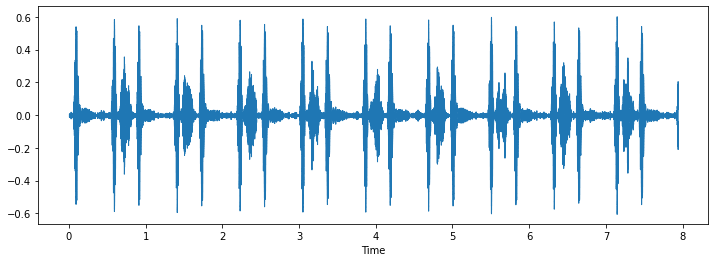

In [ ]:
import librosa.display
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y2, sr=sr2)

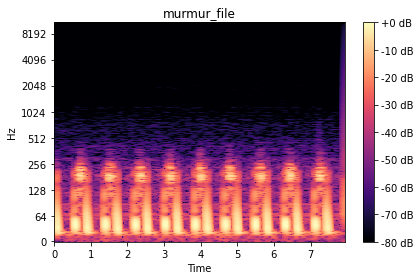

In [ ]:
# getting information from the file
time_series, sample_rate = librosa.load(murmur_file)# getting a matrix which contains amplitude values according to frequency and time indexes
stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))# converting the matrix to decibel matrix
spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')
plt.title('murmur_file')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

3. Extrasystole


Extrasystole sounds may appear occasionally and can be identified because there is a heart sound that is out of rhythm involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a “lub dub-dub”. (This is not the same as an extra heart sound as the event is not regularly occuring.) An extrasystole may not be a sign of disease. It can happen normally in an adult and can be very common in children. However, in some situations extrasystoles can be caused by heart diseases. If these diseases are detected earlier, then treatment is likely to be more effective. (source: Rita Getz)

In [ ]:
# Extrasystole case
extrastole_file=INPUT_DIR+"/set_b/extrastole__127_1306764300147_C2.wav"
y3, sr3 = librosa.load(extrastole_file)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y3.shape,sr3)

duration: 4.963809523809524
(103106,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(extrastole_file) 

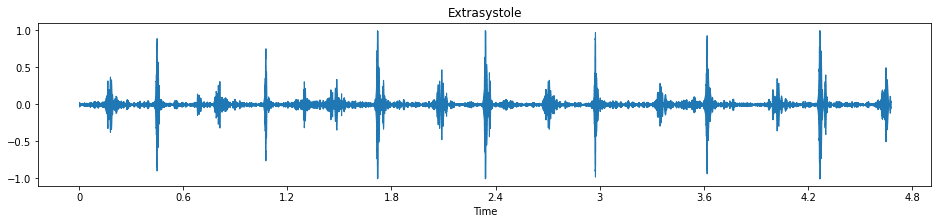

In [ ]:
# show it
plt.figure(figsize=(16, 3))
plt.title("Extrasystole")
librosa.display.waveshow(y3, sr=sr3)

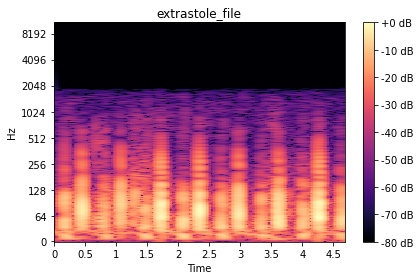

In [ ]:
# getting information from the file
time_series, sample_rate = librosa.load(extrastole_file)# getting a matrix which contains amplitude values according to frequency and time indexes
stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))# converting the matrix to decibel matrix
spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')
plt.title('extrastole_file')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

4. Artifact
In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.(source: Rita Getz)

In [ ]:
# sample file
artifact_file=INPUT_DIR+"/set_a/artifact__201012172012.wav"
y4, sr4 = librosa.load(artifact_file)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y4.shape,sr4)

duration: 4.963809523809524
(198450,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(artifact_file) 

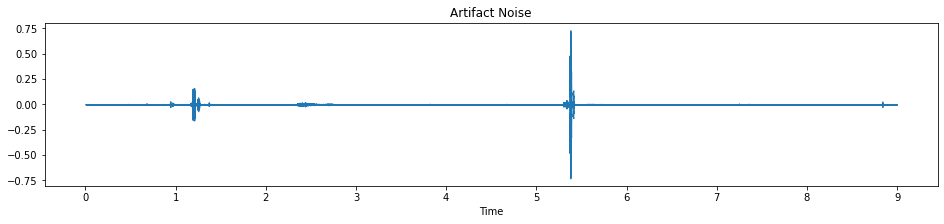

In [ ]:
# show it
plt.figure(figsize=(16, 3))
plt.title("Artifact Noise")
librosa.display.waveshow(y4, sr=sr4)

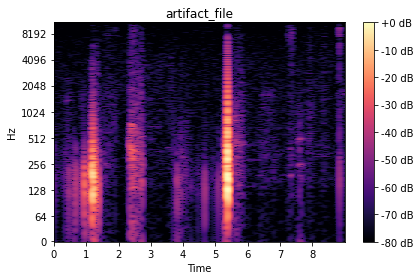

In [ ]:
# getting information from the file
time_series, sample_rate = librosa.load(artifact_file)# getting a matrix which contains amplitude values according to frequency and time indexes
stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))# converting the matrix to decibel matrix
spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')
plt.title('artifact_file')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

5. Extra Heart Sound


In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.(source: Rita Getz)

In [ ]:
# sample file
extrahls_file=INPUT_DIR+"/set_a/extrahls__201101070953.wav"
y5, sr5 = librosa.load(extrahls_file)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y5.shape,sr5)

duration: 4.963809523809524
(195894,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(extrahls_file)

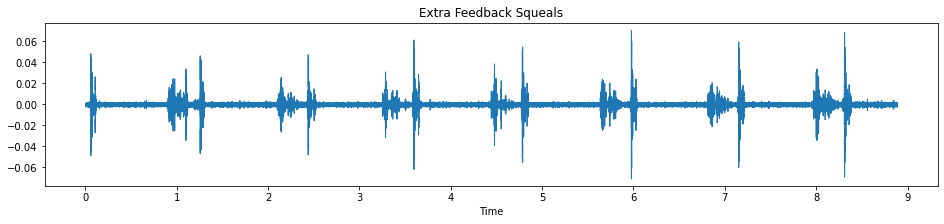

In [ ]:
# show it
plt.figure(figsize=(16, 3))
plt.title("Extra Feedback Squeals")
librosa.display.waveshow(y5, sr=sr5)

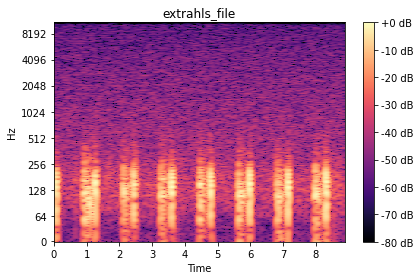

In [ ]:
# getting information from the file
time_series, sample_rate = librosa.load(extrahls_file)# getting a matrix which contains amplitude values according to frequency and time indexes
stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))# converting the matrix to decibel matrix
spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')
plt.title('extrahls_file')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [ ]:

bird_sample_list = ['normal', 'murmur', 'extrastole', 'artifact', 'extraheatsound'  ]

# Importing the 5 files
y_amered, sr_amered = librosa.load(normal_file)
audio_amered, _ = librosa.effects.trim(y_amered)

y_cangoo, sr_cangoo = librosa.load(murmur_file)
audio_cangoo, _ = librosa.effects.trim(y_cangoo)

y_haiwoo, sr_haiwoo = librosa.load(extrastole_file)
audio_haiwoo, _ = librosa.effects.trim(y_haiwoo)

y_pingro, sr_pingro = librosa.load(artifact_file)
audio_pingro, _ = librosa.effects.trim(y_pingro)

y_vesspa, sr_vesspa = librosa.load(extrahls_file)
audio_vesspa, _ = librosa.effects.trim(y_vesspa)




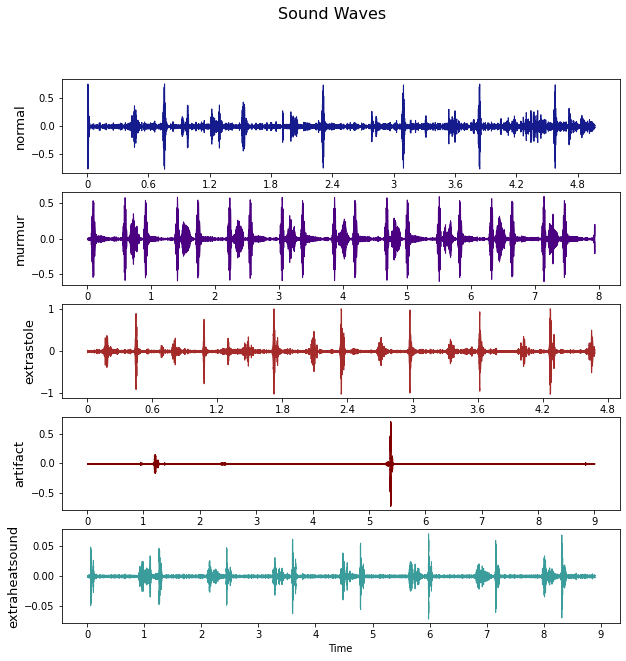

In [ ]:
fig, ax = plt.subplots(5, figsize = (10, 10))
fig.suptitle('Sound Waves', fontsize=16)

librosa.display.waveshow(y = audio_amered, sr = sr, color = "#151B8D", ax=ax[0])
librosa.display.waveshow(y = audio_cangoo, sr = sr, color = "#4B0082", ax=ax[1])
librosa.display.waveshow(y = audio_haiwoo, sr = sr, color = "#A52A2A", ax=ax[2])
librosa.display.waveshow(y = audio_pingro, sr = sr, color = "#800000", ax=ax[3])
librosa.display.waveshow(y = audio_vesspa, sr = sr, color = "#3B9C9C", ax=ax[4])


for i, name in zip(range(5), bird_sample_list):
    ax[i].set_ylabel(name, fontsize=13)

In [ ]:
dataset = []
for folder in ["../input/heartbeat-sounds/set_a/**","../input/heartbeat-sounds/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        
                        dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })
                       
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 168 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1441 non-null   object 
 1   label     1441 non-null   object 
 2   offset    1441 non-null   float64
dtypes: float64(1), object(2)
memory usage: 45.0+ KB


In [ ]:
music="/kaggle/input/heartbeat-sounds/set_a/"
import librosa
import IPython.display as ipd
x,sr=librosa.load(music+"normal__201106221418.wav")
ipd.Audio(x,rate=sr)

In [ ]:
dataset.head()

filename   label    offset
168   ../input/heartbeat-sounds/set_a/murmur__201108...  murmur  4.467778
1001  ../input/heartbeat-sounds/set_b/murmur__200_13...  murmur  0.387125
549   ../input/heartbeat-sounds/set_b/murmur__203_13...  murmur  2.316250
65    ../input/heartbeat-sounds/set_a/murmur__201104...  murmur  6.000000
629   ../input/heartbeat-sounds/set_b/normal__286_13...  normal  0.693375

In [ ]:
dataset.tail()

filename   label     offset
1095  ../input/heartbeat-sounds/set_b/normal_noisyno...  normal   0.451875
1130  ../input/heartbeat-sounds/set_b/normal_noisyno...  normal   0.670500
1294  ../input/heartbeat-sounds/set_b/murmur__116_13...  murmur  16.580000
860   ../input/heartbeat-sounds/set_b/murmur__276_13...  murmur   2.608500
1126  ../input/heartbeat-sounds/set_b/normal_noisyno...  normal   8.001375

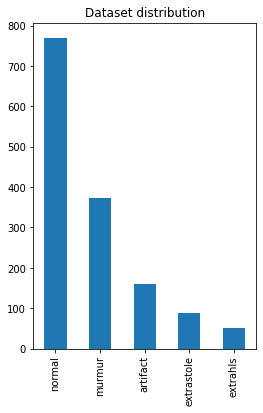

In [ ]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

**Machine Leaning**

In [ ]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    
    return data

In [ ]:
def stretch_process(data,rate=0.8):
    
    return librosa.effects.time_stretch(data,rate)

In [ ]:
def shift_process(data):
    shift_range = int(np.random.uniform(low=-5,high=5) * 1000)
    
    return np.roll(data,shift_range)

In [ ]:
def pitch_process(data,sampling_rate,pitch_factor=0.7):
    
    return librosa.effects.pitch_shift(data,sampling_rate,pitch_factor)

In [ ]:
SAMPLE_RATE = 44100
# Generate mfcc features with mean and standard deviation
from scipy.stats import skew
def extract_process(data):
    output_result = np.array([])
    ft1 = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=40)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]
    stft_out = np.abs(librosa.stft(data))
    ft7 = librosa.feature.chroma_stft(S=stft_out, sr=SAMPLE_RATE)[0]
    ft8 = librosa.feature.rms(data)[0]
    ft9 = librosa.feature.melspectrogram(data)[0]
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    ft7_trunc = np.hstack((np.mean(ft7), np.std(ft7), skew(ft7), np.max(ft7), np.median(ft7), np.max(ft7)))
    ft8_trunc = np.hstack((np.mean(ft8), np.std(ft8), skew(ft8), np.max(ft8), np.median(ft8), np.max(ft8)))
    ft9_trunc = np.hstack((np.mean(ft9), np.std(ft9), skew(ft9), np.max(ft9), np.median(ft9), np.max(ft9)))
    output_result = np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc, ft7_trunc, ft8_trunc, ft9_trunc))
    return output_result


In [ ]:
def export_process(path):
    
    data,sample_rate = librosa.load(path)
    
    output_1 = extract_process(data)
    result = np.array(output_1)
    
    noise_out = add_noise(data)
    output_2 = extract_process(noise_out)
    result = np.vstack((result,output_2))
    
#     new_out = stretch_process(data)
#     strectch_pitch = pitch_process(new_out,sample_rate)
#     output_3 = extract_process(strectch_pitch)
#     result = np.vstack((result,output_3))
    
    return result

In [ ]:
dataset.head()

filename   label    offset
168   ../input/heartbeat-sounds/set_a/murmur__201108...  murmur  4.467778
1001  ../input/heartbeat-sounds/set_b/murmur__200_13...  murmur  0.387125
549   ../input/heartbeat-sounds/set_b/murmur__203_13...  murmur  2.316250
65    ../input/heartbeat-sounds/set_a/murmur__201104...  murmur  6.000000
629   ../input/heartbeat-sounds/set_b/normal__286_13...  normal  0.693375

In [ ]:
%time
x_Train, y_Train = [],[]

for path,emotion in zip(dataset.filename,dataset.label):
    
    features = export_process(path)
    
    for element in features:
        x_Train.append(element)
        y_Train.append(emotion)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


KeyboardInterrupt: 

In [ ]:
print(len(x_Train))
print(len(y_Train))
print(len(dataset.filename))

In [ ]:
New_Features_Wav = pd.read_csv('/kaggle/input/new-heart-sound-gpu-add-noise/New_heart_sound_gpu_Add_noise.csv')

In [ ]:
# New_Features_Wav = pd.DataFrame(x_Train)
# New_Features_Wav["labels"] = y_Train

# New_Features_Wav.to_csv("New_heart_sound_gpu_Add_noise.csv",index=False)

In [ ]:
New_Features_Wav.head(-1)

0           1          2          3          4          5  \
0    -471.506775  111.093567  83.654457  54.290272  32.886890  21.656721   
1    -283.587426   37.683812  39.312371  35.273914  28.716325  22.102596   
2    -321.970673  221.096970  17.716862 -28.930779  24.854717  25.452501   
3    -249.702484  148.299156  33.249535 -10.342417  11.259641  19.083668   
4    -354.071014  199.011230  30.044950 -12.510955  24.014185  17.229038   
...          ...         ...        ...        ...        ...        ...   
2876 -432.459473  219.725861  15.212447 -14.447727  44.601738  24.727785   
2877 -332.616864  118.858285  37.115924  11.435805  24.988287  16.084617   
2878 -380.191376  153.411621  32.301762   0.193606  30.979383  31.779800   
2879 -277.565232   68.414251  37.631598  19.999478  20.836241  20.704830   
2880 -420.594513  207.030869  11.961108 -15.292961  44.299858  29.546074   

              6          7          8         9  ...       279       280  \
0     16.003592  10.655599   4.413377 -0.477670  ...  0.228868  0.024515   
1     16.138801  10.814032   6.403930  3.094688  ...  0.228870  0.025410   
2     -6.040356   3.448406  17.880203  0.731777  ...  0.247105  0.064928   
3      5.356267   3.523971   9.330301  4.157029  ...  0.247063  0.064994   
4     -9.415369   2.490695  15.578203 -1.019417  ...  0.261703  0.028865   
...         ...        ...        ...       ...  ...       ...       ...   
2876 -20.635696  -1.868616  19.999399 -3.208622  ...  0.086424  0.017614   
2877  -4.356369  -1.912204   8.060432  1.533635  ...  0.086432  0.017700   
2878   7.199531   5.890112  14.604115  5.520411  ...  0.299523  0.026366   
2879  14.863364  10.089334   8.324637  5.816541  ...  0.299571  0.026889   
2880 -12.353261   2.616672  19.078506 -4.984090  ...  0.099342  0.017141   

           281         282         283       284          285       286  \
0     0.228868  125.811401  300.062897  2.566050  1239.357666  5.455830   
1     0.228870  125.727661  299.889416  2.566380  1237.281641  5.542330   
2     0.247105   58.741489  117.626450  2.787024   643.528564  7.970255   
3     0.247063   58.734777  117.606551  2.786679   643.514261  7.997457   
4     0.261703   44.665890  115.229073  3.913021   749.808105  4.538555   
...        ...         ...         ...       ...          ...       ...   
2876  0.086424    2.833507    5.691501  3.798485    44.163425  0.966831   
2877  0.086432    2.832445    5.687226  3.801486    44.355198  0.973216   
2878  0.299523   28.509420   72.865089  3.677435   475.022797  2.089253   
2879  0.299571   28.532682   72.949214  3.681015   475.250806  2.063945   
2880  0.099342    7.355461   15.980535  3.447316   111.859283  1.528039   

              287  labels  
0     1239.357666  murmur  
1     1237.281641  murmur  
2      643.528564  murmur  
3      643.514261  murmur  
4      749.808105  murmur  
...           ...     ...  
2876    44.163425  murmur  
2877    44.355198  murmur  
2878   475.022797  murmur  
2879   475.250806  murmur  
2880   111.859283  normal  

[2881 rows x 289 columns]

In [ ]:
New_Features_Wav.tail()

0           1          2          3          4          5  \
2877 -332.616864  118.858285  37.115924  11.435805  24.988287  16.084617   
2878 -380.191376  153.411621  32.301762   0.193606  30.979383  31.779800   
2879 -277.565232   68.414251  37.631598  19.999478  20.836241  20.704830   
2880 -420.594513  207.030869  11.961108 -15.292961  44.299858  29.546074   
2881 -251.438443   57.292403  33.714817  19.104870  16.804373  13.952937   

              6          7          8         9  ...       279       280  \
2877  -4.356369  -1.912204   8.060432  1.533635  ...  0.086432  0.017700   
2878   7.199531   5.890112  14.604115  5.520411  ...  0.299523  0.026366   
2879  14.863364  10.089334   8.324637  5.816541  ...  0.299571  0.026889   
2880 -12.353261   2.616672  19.078506 -4.984090  ...  0.099342  0.017141   
2881   8.351354   5.498415   4.230714  0.836804  ...  0.099407  0.018929   

           281        282        283       284         285       286  \
2877  0.086432   2.832445   5.687226  3.801486   44.355198  0.973216   
2878  0.299523  28.509420  72.865089  3.677435  475.022797  2.089253   
2879  0.299571  28.532682  72.949214  3.681015  475.250806  2.063945   
2880  0.099342   7.355461  15.980535  3.447316  111.859283  1.528039   
2881  0.099407   7.365636  15.979077  3.445518  111.388450  1.530082   

             287  labels  
2877   44.355198  murmur  
2878  475.022797  murmur  
2879  475.250806  murmur  
2880  111.859283  normal  
2881  111.388450  normal  

[5 rows x 289 columns]

In [ ]:
print(New_Features_Wav["labels"].value_counts())

normal        1538
murmur         746
artifact       320
extrastole     176
extrahls       102
Name: labels, dtype: int64


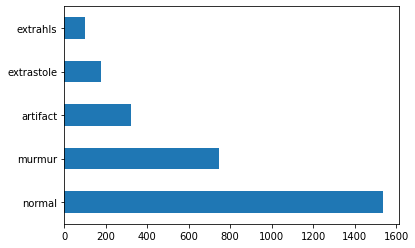

In [ ]:

%matplotlib inline

New_Features_Wav["labels"].value_counts().plot(kind='barh')
plt.savefig('events_count.pdf', dpi=1)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder_label = OneHotEncoder()

In [ ]:
scaler_data = StandardScaler()

In [ ]:
New_Features_Wav.head()

0           1          2          3          4          5  \
0 -471.506775  111.093567  83.654457  54.290272  32.886890  21.656721   
1 -283.587426   37.683812  39.312371  35.273914  28.716325  22.102596   
2 -321.970673  221.096970  17.716862 -28.930779  24.854717  25.452501   
3 -249.702484  148.299156  33.249535 -10.342417  11.259641  19.083668   
4 -354.071014  199.011230  30.044950 -12.510955  24.014185  17.229038   

           6          7          8         9  ...       279       280  \
0  16.003592  10.655599   4.413377 -0.477670  ...  0.228868  0.024515   
1  16.138801  10.814032   6.403930  3.094688  ...  0.228870  0.025410   
2  -6.040356   3.448406  17.880203  0.731777  ...  0.247105  0.064928   
3   5.356267   3.523971   9.330301  4.157029  ...  0.247063  0.064994   
4  -9.415369   2.490695  15.578203 -1.019417  ...  0.261703  0.028865   

        281         282         283       284          285       286  \
0  0.228868  125.811401  300.062897  2.566050  1239.357666  5.455830   
1  0.228870  125.727661  299.889416  2.566380  1237.281641  5.542330   
2  0.247105   58.741489  117.626450  2.787024   643.528564  7.970255   
3  0.247063   58.734777  117.606551  2.786679   643.514261  7.997457   
4  0.261703   44.665890  115.229073  3.913021   749.808105  4.538555   

           287  labels  
0  1239.357666  murmur  
1  1237.281641  murmur  
2   643.528564  murmur  
3   643.514261  murmur  
4   749.808105  murmur  

[5 rows x 289 columns]

In [ ]:
X = New_Features_Wav.iloc[:,:-1].values
Y = New_Features_Wav["labels"].values

In [ ]:
print(X.shape)
print(Y.shape)

(2882, 288)
(2882,)


In [ ]:
Y = encoder_label.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
print(Y.shape)

(2882, 5)


In [ ]:
xTrain,xTest,yTrain,yTest = train_test_split(X,Y,train_size=0.8,random_state=42)

In [ ]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(2305, 288)
(2305, 5)
(577, 288)
(577, 5)


In [ ]:
xTrain = scaler_data.fit_transform(xTrain)
xTest = scaler_data.transform(xTest)

In [ ]:
print(xTrain.shape)
print(xTest.shape)

(2305, 288)
(577, 288)


# 1. **Machine Leaning Models**

# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(max_depth= 8,
 max_features= 5,
 min_samples_split=5,
 n_estimators=500).fit(xTrain,yTrain)
forest

RandomForestClassifier(max_depth=8, max_features=5, min_samples_split=5,
                       n_estimators=500)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred=forest.predict(xTest)
accuracy_score(yTest,y_pred)

0.8093587521663779

In [ ]:
#Making prediction
from sklearn.metrics import plot_roc_curve

predictions7 = forest.predict(xTest)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(yTest, predictions7))
accuracyScore = accuracy_score(predictions7, yTest )
print("Accuracy score after train test split (RF): ", accuracyScore * 100.0)



              precision    recall  f1-score   support

           0       0.97      0.97      0.97        73
           1       1.00      0.71      0.83        21
           2       0.00      0.00      0.00        23
           3       1.00      0.53      0.69       142
           4       0.81      0.96      0.88       318

   micro avg       0.86      0.81      0.84       577
   macro avg       0.76      0.64      0.68       577
weighted avg       0.85      0.81      0.81       577
 samples avg       0.81      0.81      0.81       577

Accuracy score after train test split (RF):  80.93587521663778


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
nb_classes=New_Features_Wav["labels"].unique()

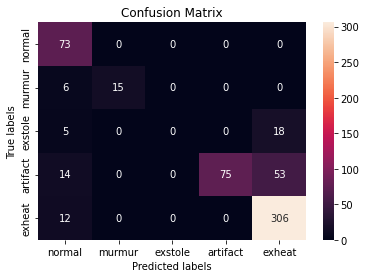

In [ ]:
import seaborn as sns

T5_lables = ['normal', 'murmur', 'exstole', 'artifact', 'exheat'  ]  

ax= plt.subplot()

cm = confusion_matrix(np.asarray(yTest).argmax(axis=1), np.asarray(predictions7).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier().fit(xTrain,yTrain)
mlp

MLPClassifier()

In [ ]:
y_pred_mlp=mlp.predict(xTest)
accuracy_score(yTest,y_pred_mlp)

0.9566724436741768

In [ ]:
#Making prediction
from sklearn.metrics import plot_roc_curve

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(yTest, y_pred_mlp))
accuracyScore = accuracy_score(y_pred_mlp, yTest )
print("Accuracy score after train test split (MLP): ", accuracyScore * 100.0)



              precision    recall  f1-score   support

           0       0.99      1.00      0.99        73
           1       0.91      1.00      0.95        21
           2       0.90      0.78      0.84        23
           3       0.97      0.97      0.97       142
           4       0.98      0.97      0.97       318

   micro avg       0.97      0.97      0.97       577
   macro avg       0.95      0.95      0.95       577
weighted avg       0.97      0.97      0.97       577
 samples avg       0.96      0.97      0.96       577

Accuracy score after train test split (MLP):  95.66724436741768


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


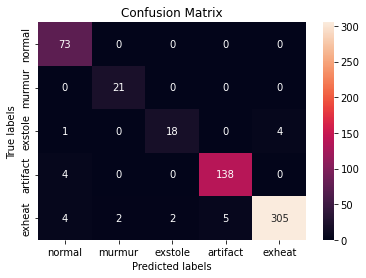

In [ ]:
import seaborn as sns

T5_lables = ['normal', 'murmur', 'exstole', 'artifact', 'exheat'  ]  

ax= plt.subplot()

cm = confusion_matrix(np.asarray(yTest).argmax(axis=1), np.asarray(y_pred_mlp).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

# XGB

In [ ]:
import xgboost as xgb

In [ ]:
# Optimal model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
# Optimal model
clf1 = xgb.XGBClassifier()




clf1.fit(xTrain, yTrain)
predictionsxgb=clf1.predict(xTest)


from sklearn.metrics import classification_report
print(classification_report(yTest, predictionsxgb))
accuracyScore = accuracy_score(predictionsxgb, yTest )
print("Accuracy score after train test split (xgb): ", accuracyScore * 100.0)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98        73
           1       1.00      1.00      1.00        21
           2       1.00      0.78      0.88        23
           3       0.99      0.95      0.97       142
           4       0.97      0.98      0.97       318

   micro avg       0.97      0.97      0.97       577
   macro avg       0.98      0.94      0.96       577
weighted avg       0.97      0.97      0.97       577
 samples avg       0.96      0.97      0.96       577

Accuracy score after train test split (xgb):  95.32062391681109


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



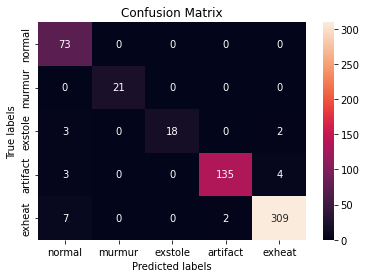

In [ ]:
import seaborn as sns

T5_lables = ['normal', 'murmur', 'exstole', 'artifact', 'exheat'  ]  

ax= plt.subplot()

cm = confusion_matrix(np.asarray(yTest).argmax(axis=1), np.asarray(predictionsxgb).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Optimal model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
# Optimal model
knn = KNeighborsClassifier()




knn.fit(xTrain, yTrain)
predictionsknn=knn.predict(xTest)


from sklearn.metrics import classification_report
print(classification_report(yTest, predictionsknn))
accuracyScore = accuracy_score(predictionsknn, yTest )
print("Accuracy score after train test split (knn): ", accuracyScore * 100.0)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99        73
           1       0.81      1.00      0.89        21
           2       0.75      0.65      0.70        23
           3       0.94      0.86      0.90       142
           4       0.93      0.93      0.93       318

   micro avg       0.93      0.91      0.92       577
   macro avg       0.88      0.89      0.88       577
weighted avg       0.93      0.91      0.92       577
 samples avg       0.91      0.91      0.91       577

Accuracy score after train test split (knn):  91.16117850953206


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



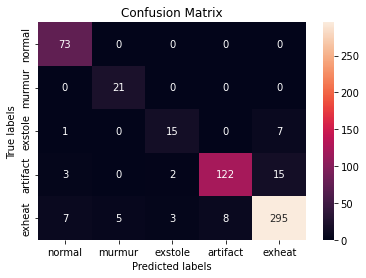

In [ ]:
import seaborn as sns

T5_lables = ['normal', 'murmur', 'exstole', 'artifact', 'exheat'  ]  

ax= plt.subplot()

cm = confusion_matrix(np.asarray(yTest).argmax(axis=1), np.asarray(predictionsknn).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

# DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Optimal model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
# Optimal model
dt = DecisionTreeClassifier()




dt.fit(xTrain, yTrain)
predictionsdt=dt.predict(xTest)


from sklearn.metrics import classification_report
print(classification_report(yTest, predictionsdt))
accuracyScore = accuracy_score(predictionsdt, yTest )
print("Accuracy score after train test split (dt): ", accuracyScore * 100.0)


              precision    recall  f1-score   support

           0       0.97      0.95      0.96        73
           1       0.85      0.81      0.83        21
           2       0.55      0.74      0.63        23
           3       0.82      0.86      0.84       142
           4       0.93      0.90      0.91       318

   micro avg       0.88      0.88      0.88       577
   macro avg       0.82      0.85      0.83       577
weighted avg       0.89      0.88      0.89       577
 samples avg       0.88      0.88      0.88       577

Accuracy score after train test split (dt):  88.38821490467937


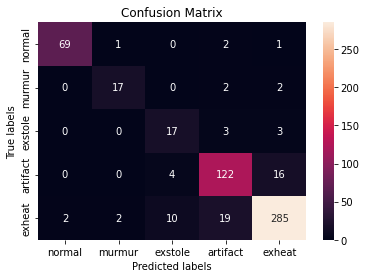

In [ ]:
import seaborn as sns

T5_lables = ['normal', 'murmur', 'exstole', 'artifact', 'exheat'  ]  

ax= plt.subplot()

cm = confusion_matrix(np.asarray(yTest).argmax(axis=1), np.asarray(predictionsdt).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

# Deep Leaning

In [ ]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
#IMAGE PROCESS
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
import imageio
from IPython.display import Image
import matplotlib.image as mpimg
#MUSIC PROCESS
import pydub
from scipy.io.wavfile import read, write
import librosa
import librosa.display
import IPython
from IPython.display import Audio
import scipy
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
#OPTIMIZER
# from keras.optimizers import Adam,Optimizer,Optimizer, SGD
from tensorflow.keras.optimizers import Adam,Optimizer,Optimizer, SGD
#MODEL LAYERS
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape,\
Conv2DTranspose, LeakyReLU, Conv1D, AveragePooling1D, MaxPooling1D
from keras import models
from keras import layers
import tensorflow as tf
from tensorflow.keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
import keras
#SKLEARN CLASSIFIER
# from xgboost import XGBClassifier, XGBRegressor
# from lightgbm import LGBMClassifier, LGBMRegressor
# from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
#IGNORING WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [ ]:
print(xTrain.shape)
print(xTest.shape)

(2305, 288)
(577, 288)


In [ ]:

xTrain = np.expand_dims(xTrain,axis=2)
xTest = np.expand_dims(xTest,axis=2)

In [ ]:
print(xTrain.shape)
print(xTest.shape)

(2305, 288, 1)
(577, 288, 1)


In [ ]:
Model=Sequential()
Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(xTrain.shape[1], 1)))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
Model.add(Dropout(0.2))

Model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Flatten())
Model.add(Dense(units=32, activation='relu'))
Model.add(Dropout(0.3))

Model.add(Dense(units=5, activation='softmax'))

In [ ]:
Model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 288, 256)          1536      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 144, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 144, 256)          327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 72, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 72, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 36, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 128)          

In [ ]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [ ]:
Conv1D_Model = Model.fit(xTrain, yTrain, batch_size=64, epochs=90, validation_data=(xTest, yTest))
# Conv1D_Model = Model.fit(xTrain, yTrain, batch_size=64, epochs=90, validation_split=0.2)

Epoch 1/90


2023-01-11 18:47:58.475571: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


37/37 [==============================] - 8s 18ms/step - loss: 1.3187 - accuracy: 0.5193 - val_loss: 1.0540 - val_accuracy: 0.6256
Epoch 2/90
37/37 [==============================] - 0s 10ms/step - loss: 1.0749 - accuracy: 0.5922 - val_loss: 0.8897 - val_accuracy: 0.6464
Epoch 3/90
37/37 [==============================] - 0s 10ms/step - loss: 1.0061 - accuracy: 0.5996 - val_loss: 0.7913 - val_accuracy: 0.6950
Epoch 4/90
37/37 [==============================] - 0s 10ms/step - loss: 0.9002 - accuracy: 0.6655 - val_loss: 0.7511 - val_accuracy: 0.7244
Epoch 5/90
37/37 [==============================] - 0s 11ms/step - loss: 0.7871 - accuracy: 0.6989 - val_loss: 0.7538 - val_accuracy: 0.6516
Epoch 6/90
37/37 [==============================] - 0s 12ms/step - loss: 0.8523 - accuracy: 0.6746 - val_loss: 0.6256 - val_accuracy: 0.7504
Epoch 7/90
37/37 [==============================] - 0s 12ms/step - loss: 0.7137 - accuracy: 0.7184 - val_loss: 0.5408 - val_accuracy: 0.7764
Epoch 8/90
37/37 [======

<Figure size 720x720 with 0 Axes>

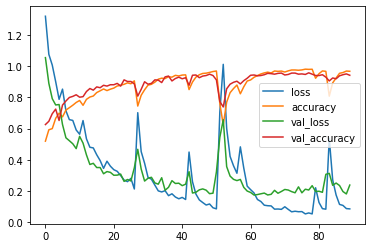

In [ ]:
Grap_Data = pd.DataFrame(Conv1D_Model.history)
figure = plt.figure(figsize=(10,10))
Grap_Data.plot()
plt.savefig('CNN_all_loss_accuracy.pdf', dpi=1)

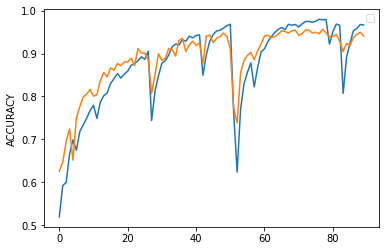

In [ ]:
plt.plot(Conv1D_Model.history["accuracy"])
plt.plot(Conv1D_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.savefig('CNN_accuracy.pdf', dpi=1)
plt.show()


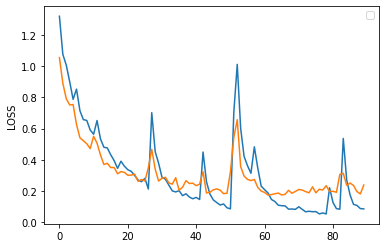

In [ ]:
plt.plot(Conv1D_Model.history["loss"])
plt.plot(Conv1D_Model.history["val_loss"])
plt.ylabel("LOSS")
plt.legend()
plt.savefig('CNN_loss.pdf', dpi=1)
plt.show()


In [ ]:
Model_Results = Model.evaluate(xTest,yTest)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

19/19 [==============================] - 0s 4ms/step - loss: 0.2384 - accuracy: 0.9411
LOSS:  0.2384
ACCURACY:  0.9411


In [ ]:
prediction_test = Model.predict(xTest)
y_prediction = encoder_label.inverse_transform(prediction_test)

yTest = encoder_label.inverse_transform(yTest)

In [ ]:
print(y_prediction[0:10])

[['extrastole']
 ['normal']
 ['normal']
 ['murmur']
 ['normal']
 ['normal']
 ['murmur']
 ['normal']
 ['normal']
 ['normal']]


In [ ]:
print(yTest[0:10])

[['extrastole']
 ['normal']
 ['murmur']
 ['murmur']
 ['normal']
 ['normal']
 ['murmur']
 ['normal']
 ['normal']
 ['normal']]


In [ ]:
conf_matrix = confusion_matrix(yTest, y_prediction)

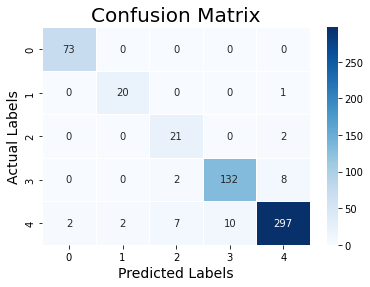

In [ ]:
sns.heatmap(conf_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('CNN_confusion_matrix.pdf', dpi=1)
plt.show()


In [ ]:
print(classification_report(yTest, y_prediction))

              precision    recall  f1-score   support

    artifact       0.97      1.00      0.99        73
    extrahls       0.91      0.95      0.93        21
  extrastole       0.70      0.91      0.79        23
      murmur       0.93      0.93      0.93       142
      normal       0.96      0.93      0.95       318

    accuracy                           0.94       577
   macro avg       0.90      0.95      0.92       577
weighted avg       0.94      0.94      0.94       577



# ANN MODEL

In [ ]:
X = New_Features_Wav.iloc[:,:-1].values
Y = New_Features_Wav["labels"].values
Y = encoder_label.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=0.8,random_state=42)

In [ ]:
y_train.shape

(2305, 5)

In [ ]:
X_train.shape

(2305, 288)

In [ ]:
# Construct model

# num_labels = Y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(1000, activation="relu", input_shape=(X_train.shape[1],)))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dense(500, activation="relu"))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dense(5, activation="softmax"))
ANN_Model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1000)              289000    
_________________________________________________________________
dense_12 (Dense)             (None, 750)               750750    
_________________________________________________________________
dense_13 (Dense)             (None, 500)               375500    
_________________________________________________________________
dense_14 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_15 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                

In [ ]:
import time

ANN_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

num_epochs = 90
num_batch_size = 64

t0 = time.time()

ANN_Results = ANN_Model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
)

train_hist_m1 = pd.DataFrame(ANN_Results.history)
train_m1 = round(time.time() - t0, 3)


Epoch 1/90
37/37 [==============================] - 1s 9ms/step - loss: 71.3196 - accuracy: 0.4065 - val_loss: 8.9633 - val_accuracy: 0.3899
Epoch 2/90
37/37 [==============================] - 0s 4ms/step - loss: 7.2243 - accuracy: 0.5050 - val_loss: 4.1108 - val_accuracy: 0.6378
Epoch 3/90
37/37 [==============================] - 0s 4ms/step - loss: 2.1945 - accuracy: 0.5627 - val_loss: 5.2900 - val_accuracy: 0.3033
Epoch 4/90
37/37 [==============================] - 0s 4ms/step - loss: 3.3684 - accuracy: 0.5588 - val_loss: 7.2850 - val_accuracy: 0.2340
Epoch 5/90
37/37 [==============================] - 0s 4ms/step - loss: 1.5532 - accuracy: 0.6134 - val_loss: 1.1689 - val_accuracy: 0.6343
Epoch 6/90
37/37 [==============================] - 0s 4ms/step - loss: 1.3270 - accuracy: 0.6265 - val_loss: 1.0974 - val_accuracy: 0.6464
Epoch 7/90
37/37 [==============================] - 0s 4ms/step - loss: 1.0961 - accuracy: 0.6633 - val_loss: 2.1519 - val_accuracy: 0.4229
Epoch 8/90
37/37 [=

<Figure size 720x720 with 0 Axes>

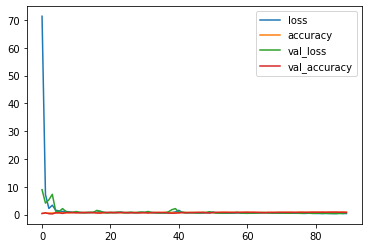

In [ ]:
train_hist_m1 = pd.DataFrame(ANN_Results.history)
train_m1 = round(time.time() - t0, 3)
figure = plt.figure(figsize=(10,10))
train_hist_m1.plot()
plt.savefig('ANN_all_loss_accuracy.pdf', dpi=1)

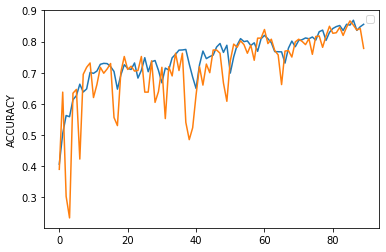

In [ ]:
plt.plot(ANN_Results.history["accuracy"])
plt.plot(ANN_Results.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.savefig('ANN_accuracy.pdf', dpi=1)
plt.show()


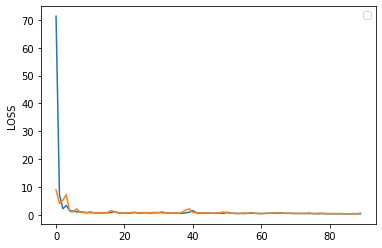

In [ ]:
plt.plot(ANN_Results.history["loss"])
plt.plot(ANN_Results.history["val_loss"])
plt.ylabel("LOSS")
plt.legend()
plt.savefig('ANN_loss.pdf', dpi=1)
plt.show()

In [ ]:
acc_m1 = ANN_Model.evaluate(X_test, y_test, verbose=0)
t0 = time.time()
y_pred_m1 = ANN_Model.predict(X_test, verbose=0)



In [ ]:
acc_m1

[0.6352577805519104, 0.7781628966331482]

In [ ]:
y_pred_m1.shape

(577, 5)

In [ ]:

y_prediction_ann = encoder_label.inverse_transform(y_pred_m1)

yTest_ann = encoder_label.inverse_transform(y_test)

In [ ]:
print(y_pred_m1[0:10])

[[3.4270951e-04 3.0971202e-03 3.1634519e-01 2.3184398e-01 4.4837099e-01]
 [7.2351548e-05 3.4168383e-04 1.1308321e-01 4.6947429e-01 4.1702852e-01]
 [3.7257259e-03 2.7144322e-02 1.3406725e-02 1.2974226e-01 8.2598096e-01]
 [2.9059846e-09 5.9039195e-07 7.3279470e-01 2.0115508e-01 6.6049621e-02]
 [7.9148185e-07 2.2278205e-06 7.1914480e-03 2.0928809e-01 7.8351754e-01]
 [7.8846590e-04 7.2905216e-03 7.7434056e-02 1.5805468e-01 7.5643224e-01]
 [5.9719114e-05 7.9130032e-06 5.0473187e-02 9.4892544e-01 5.3375523e-04]
 [2.3167613e-05 2.0535564e-04 7.1037877e-01 1.4722651e-01 1.4216614e-01]
 [1.0284838e-03 3.3552412e-02 1.6052397e-01 1.2198689e-01 6.8290824e-01]
 [4.8756684e-04 4.2051816e-04 7.6837800e-02 1.1573577e-01 8.0651838e-01]]


In [ ]:
print(y_prediction_ann[0:10])

[['normal']
 ['murmur']
 ['normal']
 ['extrastole']
 ['normal']
 ['normal']
 ['murmur']
 ['extrastole']
 ['normal']
 ['normal']]


In [ ]:
print(yTest_ann[0:10])

[['extrastole']
 ['normal']
 ['murmur']
 ['murmur']
 ['normal']
 ['normal']
 ['murmur']
 ['normal']
 ['normal']
 ['normal']]


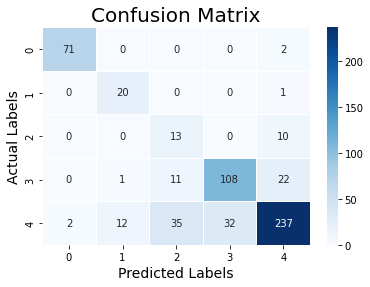

In [ ]:
conf_matrix = confusion_matrix(yTest_ann, y_prediction_ann)

sns.heatmap(conf_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('ANN_confusion_matrix.pdf', dpi=1)
plt.show()

In [ ]:
print(classification_report(yTest_ann, y_prediction_ann))

              precision    recall  f1-score   support

    artifact       0.97      0.97      0.97        73
    extrahls       0.61      0.95      0.74        21
  extrastole       0.22      0.57      0.32        23
      murmur       0.77      0.76      0.77       142
      normal       0.87      0.75      0.80       318

    accuracy                           0.78       577
   macro avg       0.69      0.80      0.72       577
weighted avg       0.82      0.78      0.79       577

